# Question 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


pd.options.display.max_columns = None
pd.set_option('display.max_colwidth', None)

DIR_CUR = "../data/curated/"
DIR_PLT = "../plots/"

### Read in data

In [4]:
df = pd.read_csv(f"{DIR_CUR}suburb_data.csv")
display(df.head(5))

,suburb,count,weekly_rent,bond,num_beds,num_baths,num_parking,internal_area,land_area,other_sold_n_bed_suburb,neighbourhood_under_20,neighbourhood_20_to_39,neighbourhood_40_to_59,neighbourhood_above_60,neighbourhood_long_term_residents,neighbourhood_owners,neighbourhood_renter,neighbourhood_family,neighbourhood_single,performance_median_price,performance_auction_clearance,performance_sold_this_year,performance_avg_days_on_market,demographic_population,demographic_owner,demographic_renter,demographic_family,demographic_single,school_distance,park_distance,shop_distance,train_distance,stop_distance,population,median_weekly_income
0,abbotsford,52,548.600000,2387.020000,2.000000,1.365385,1.195122,NaN,NaN,79.120000,0.107692,0.555577,0.230577,0.104231,0.399231,0.347600,0.652400,0.505000,0.495000,7.622340e+05,0.514255,79.916667,72.510638,8443.680000,0.396000,0.604000,0.259200,0.740800,772.030769,434.905882,1081.582609,1406.405769,398.075000,9780.153846,1323.153846
1,abeckett street,19,501.842105,2470.909091,1.421053,1.105263,1.000000,NaN,NaN,455.736842,0.063158,0.776842,0.131579,0.033684,0.180714,0.260714,0.739286,0.285714,0.714286,4.430714e+05,0.436429,463.357143,127.357143,44828.428571,0.307143,0.692857,0.242143,0.757857,707.547368,493.621053,773.422222,388.752632,321.731579,17545.368421,675.105263
2,ada,25,455.416667,2034.720000,2.680000,1.800000,1.500000,NaN,NaN,135.750000,0.209565,0.466522,0.210870,0.107826,0.573000,0.550435,0.449565,0.528261,0.471739,7.270476e+05,0.534706,135.750000,71.761905,13646.280000,0.550000,0.450000,0.391200,0.608800,1815.372000,4185.372000,6630.104762,3456.820000,537.276000,12763.040000,781.040000
3,airport west,17,428.529412,1909.142857,2.529412,1.294118,1.294118,NaN,299.0,48.588235,0.222353,0.261765,0.262941,0.251765,0.621765,0.721765,0.278235,0.545882,0.454118,7.813750e+05,0.704375,48.588235,70.928571,7567.000000,0.730000,0.270000,0.470000,0.530000,1007.452941,504.223529,1178.320000,7175.617647,260.870588,8237.000000,883.000000
4,albert park,17,900.882353,4799.375000,2.352941,1.529412,1.100000,NaN,179.0,47.470588,0.260000,0.205294,0.304706,0.227059,0.507647,0.618235,0.381765,0.595882,0.404118,1.839176e+06,0.751818,47.470588,36.454545,6210.000000,0.610000,0.390000,0.470000,0.530000,509.900000,364.858824,2331.300000,4022.794118,247.176471,16023.000000,1352.000000


## Most important data distributions

In [ ]:
def distribution(x, bins, x_lab):
    plt.hist(x, bins=bins, density=True)
    plt.title(f"{x_lab} Distribution", size=20)
    plt.xlabel(x_lab, size=16)
    plt.ylabel("Frequency", size=16)
    plt.show()
    
distribution(df["weekly_rent"], 30, "Weekly Rent (AUS)", )
#distribution(df["bond"], 30, "Bond (AUS)")
distribution(df["school_distance"], 30, "School Distance (m)")
distribution(df["park_distance"], 30, "Park Distance (m)")
distribution(df["shop_distance"], 30, "Shop Distance (m)")
distribution(df["train_distance"], 30, "Train Distance (m)")
distribution(df["stop_distance"], 30, "Stop Distance (m)")

## VS plots

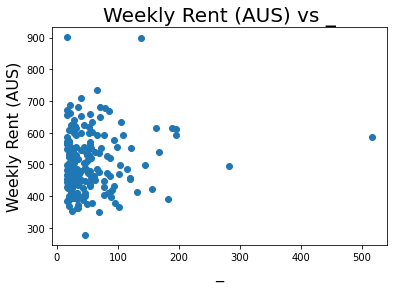

In [25]:
def vs(x, y, x_lab, y_lab, x_trans=lambda x: x, y_trans=lambda x: x):
    plt.scatter(x_trans(x), y_trans(y))
    plt.title(f"{y_lab} vs {x_lab}", size=20)
    plt.xlabel(x_lab, size=16)
    plt.ylabel(y_lab, size=16)
    plt.show()

#vs(df["school_distance"], df["weekly_rent"], "School Distance (m)", "Weekly Rent (AUS)")
#vs(df["park_distance"],   df["weekly_rent"], "Park Distance (m)",   "Weekly Rent (AUS)")
#vs(df["shop_distance"],   df["weekly_rent"], "Shop Distance (m)",   "Weekly Rent (AUS)")
#vs(df["train_distance"],  df["weekly_rent"], "Train Distance (m)",  "Weekly Rent (AUS)")
#vs(df["stop_distance"],   df["weekly_rent"], "Stop Distance (m)",   "Weekly Rent (AUS)")

#vs(df["population"], df["weekly_rent"], "Population", "Weekly Rent (AUS)")

#vs(df["count"], df["weekly_rent"], "_", "Weekly Rent (AUS)")

#vs(df["performance_avg_days_on_market"], df["weekly_rent"], "_", "Weekly Rent (AUS)")
#vs(df["median_weekly_income"], df["weekly_rent"], "median weekly income", "Weekly Rent (AUS)")
#vs(df["performance_median_price"], df["weekly_rent"], "Median Price", "Weekly Rent (AUS)")

## Model

In [27]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

response = "weekly_rent"
predictors = ["median_weekly_income", "performance_median_price"] 

df_na_out = df.dropna(subset=predictors)

trans = ColumnTransformer(transformers=[("scale", StandardScaler(), predictors)],
                          remainder="passthrough") 

x_train, x_test, y_train, y_test = train_test_split(df_na_out[predictors],
                                                    df_na_out[response],
                                                    test_size=0.20,
                                                    random_state=30027)

x_train_trans = trans.fit_transform(x_train)
x_test_trans = trans.fit_transform(x_test)

model = MLPRegressor(random_state=30027, max_iter=1000000, n_iter_no_change=15).fit(x_train_trans, y_train)
model.score(x_test_trans, y_test)

0.7632212969394286

In [28]:
from sklearn.linear_model import LinearRegression


model_2 = LinearRegression().fit(x_train_trans, y_train)
model_2.score(x_test_trans, y_test)

0.6960429513691262